# Proyecto 13

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.

Objetivo: Construye un modelo para dicha predicción; la métrica RECM en el conjunto de prueba no debe ser superior a 48.

Para lo anterior vamos a seguir estos pasos:

1.	Descargar los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
2.	Analizar los datos.
3.	Entrenar diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial. Prueba los datos usando la muestra de prueba.
    - Vamos a usar los siguientes modelos: Regresión Lineal, LightGBM, XGBRegressor para este último vamos aplicar la validación cruzada a una serie de tiempo.
4.	Conclusión



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy.random import RandomState
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import statsmodels.api as sm


## Descarga del archivo y análisis de datos.

In [2]:
try:
    df = pd.read_csv("taxi.csv", index_col= [0], parse_dates= [0])

except:
    df = pd.read_csv("/dataset/taxi.csv", index_col= [0], parse_dates= [0])

df.sort_index(inplace= True)
df = df.resample("1h").sum()

display(df)
print(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None


Lo que hicimos fue cargar el archivo de nuestra base, cambiamos el índice por las fechas que tiene la base las ordenamos por fecha y las agrupamos por hora. Ademas podemos ver que nuestra base no tiene valores nulos e inicia desde 2018-03-01 0 horas y termina 2018-08-31 23 hrs. 

Veamos como es la distribución de nuestros datos.

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


Text(0.5, 1.0, 'Histograma')

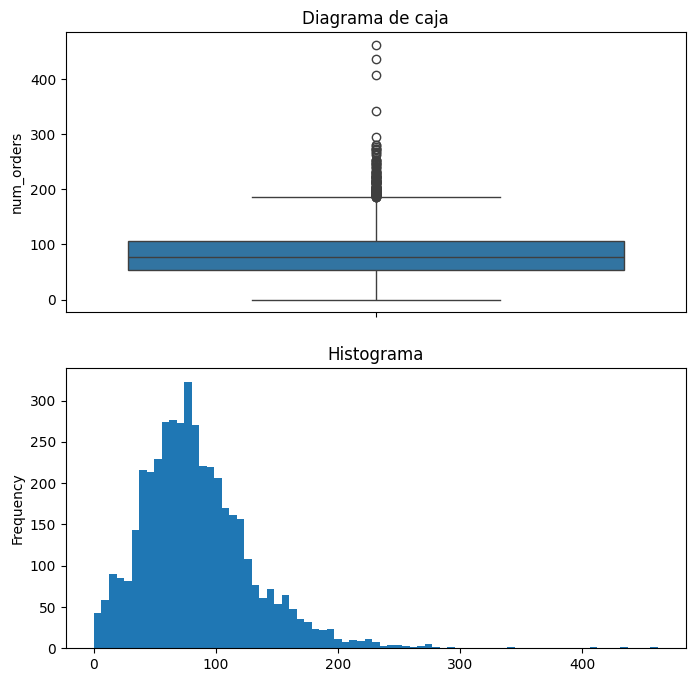

In [3]:
print(df["num_orders"].describe())

plt.figure(figsize= (8,8))

plt.subplot(211)
sns.boxplot(df["num_orders"])
plt.title("Diagrama de caja")

plt.subplot(212)
df["num_orders"].plot(kind= "hist", bins= 75)
plt.title("Histograma")




Por lo anterior, tenemos congruencia de datos es decir, no hay valores negativos. Además tenemos valores atípicos mayores a 200. Por último, la distribución de los valores es parecido a una distribución normal. 

Ahora vamos a ver como se ve nuestra serie de tiempo gráficada y sus componentes; tendencia, componente estacional y residuo.

Text(0.5, 1.0, 'Residuo')

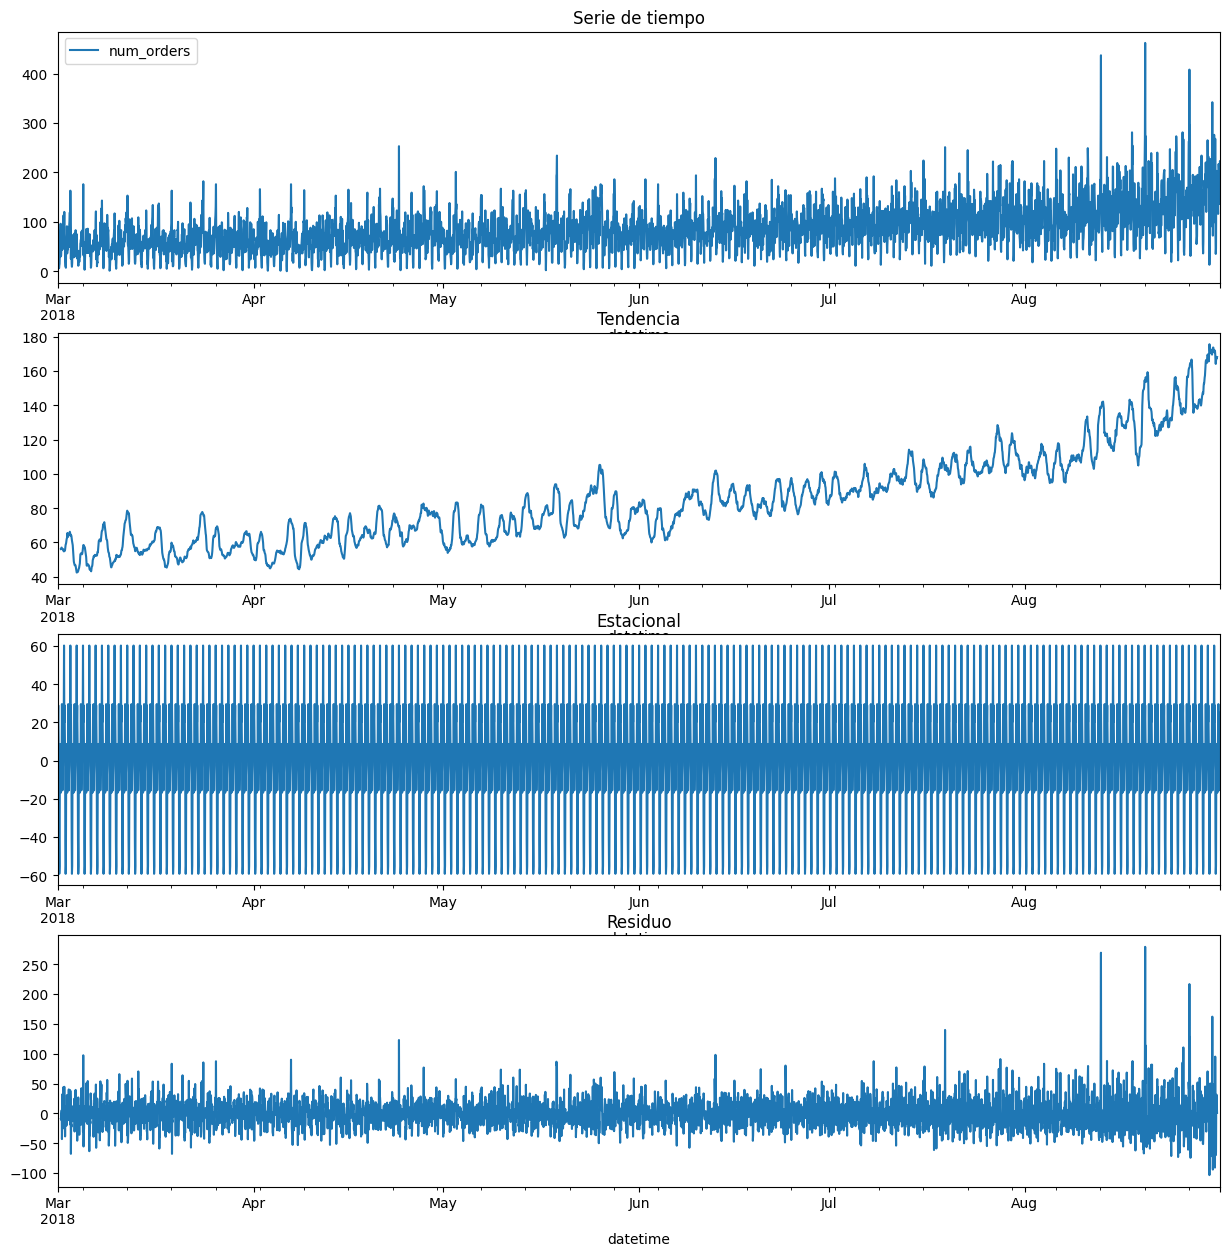

In [4]:
decompose = seasonal_decompose(df)
plt.figure(figsize= (15,15))

plt.subplot(411)
df.plot(ax= plt.gca())
plt.title("Serie de tiempo")

plt.subplot(412)
decompose.trend.plot(ax= plt.gca())
plt.title("Tendencia")

plt.subplot(413)
decompose.seasonal.plot(ax= plt.gca())
plt.title("Estacional")

plt.subplot(414)
decompose.resid.plot(ax= plt.gca())
plt.title("Residuo")

#figura, cuadrantes = plt.subplots(1,1,figsize=(10, 6))


Por lo anterior, podemos ver que nuestro la tendencia ha ido creciento, es decir cada vez se han solicitado más viajes en taxi con el paso del tiempo. En particular después de junio. Con respecto a la estacionalidad vemos que tenemos varia en un intervalo de (-60, 60).

Veamos como se distribuye la media movil y su desviación estándar movil con una ventana de 15 días.

<Axes: xlabel='datetime'>

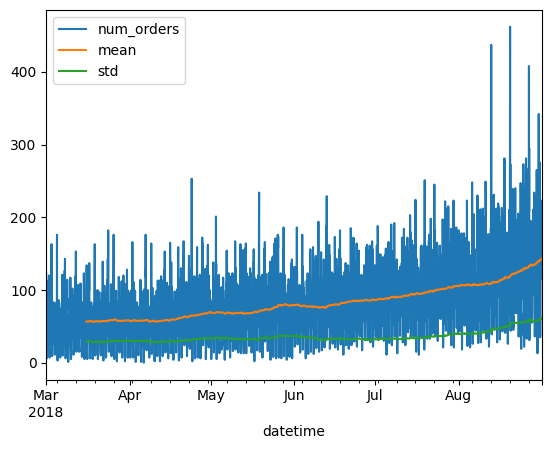

In [5]:
df["mean"] = df["num_orders"].rolling(360).mean()
df["std"] = df["num_orders"].rolling(360).std()
df.plot()

Con lo anterior, respaldamos nuestros comentarios de la tendencia.

,num_orders,mean,std,rendimiento
datetime,,,,
2018-03-01 00:00:00,124,NaN,NaN,124
2018-03-01 01:00:00,85,NaN,NaN,-39
2018-03-01 02:00:00,71,NaN,NaN,-14
2018-03-01 03:00:00,66,NaN,NaN,-5
2018-03-01 04:00:00,43,NaN,NaN,-23
...,...,...,...,...
2018-08-31 19:00:00,136,142.425000,60.409097,-71
2018-08-31 20:00:00,154,142.605556,60.346077,18
2018-08-31 21:00:00,159,142.711111,60.341414,5


205


<Axes: xlabel='datetime'>

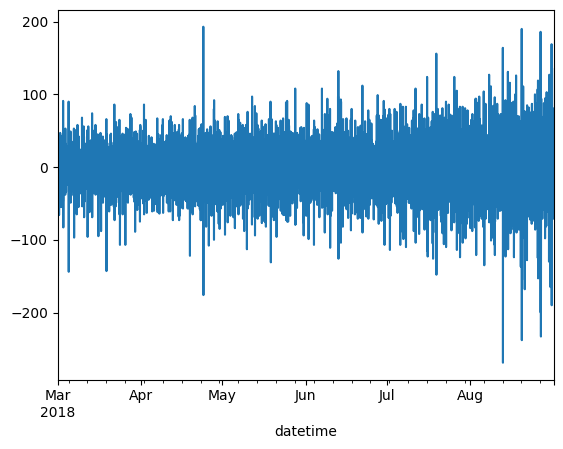

In [6]:
df["rendimiento"] = df["num_orders"] - df["num_orders"].shift(fill_value= 0)
display(df)
print(df["rendimiento"].sum())

df["rendimiento"].plot()


En conclusión:

- Tenemos congruencia de datos es decir, no hay valores negativos. Además tenemos valores atípicos mayores a 200. Por último, la distribución de los valores es parecido a una distribución normal.
- La tendencia ha ido creciento, es decir cada vez se han solicitado más viajes en taxi con el paso del tiempo. En particular después de junio. Con respecto a la estacionalidad vemos que tenemos varia en un intervalo de (-60, 60).

## Creación de características para los modelos.

Nuestra base comprende de marzo a agosto del 2018. Entonces vamos a crear las columnas con respecto al día y día de la semana.
Además vamos agregar la media móvil y algunos desfaces.

In [7]:
df["day"] = df.index.day
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["mean_6hrs"] = df["num_orders"].rolling(6).mean()
df.drop(["mean", "std", "rendimiento"], axis= 1, inplace= True)

for i in range(1,5):
    df["lag_"+ str(i)] = df["num_orders"].shift(i, fill_value= 0)

df["mean_6hrs"].fillna(0, inplace= True)

display(df)

C:\Users\snede\AppData\Local\Temp\ipykernel_4820\2626918617.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["mean_6hrs"].fillna(0, inplace= True)


,num_orders,day,dayofweek,month,mean_6hrs,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,,
2018-03-01 00:00:00,124,1,3,3,0.000000,0,0,0,0
2018-03-01 01:00:00,85,1,3,3,0.000000,124,0,0,0
2018-03-01 02:00:00,71,1,3,3,0.000000,85,124,0,0
2018-03-01 03:00:00,66,1,3,3,0.000000,71,85,124,0
2018-03-01 04:00:00,43,1,3,3,0.000000,66,71,85,124
...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,8,167.666667,207,217,197,116
2018-08-31 20:00:00,154,31,4,8,171.166667,136,207,217,197
2018-08-31 21:00:00,159,31,4,8,178.333333,154,136,207,217


Vamos a hacer la división de nuestros datos en entrenamiento y prueba donde el conjunto de prueba tendrá un tamaño del 10% de los datos totales. 

Además vamos a crear la parte de características y target para el entrenamiento de los modelos, para después ver los resultados de nuestras predicciones con la métrica RECM.

In [8]:
train, test = train_test_split(df, shuffle= False, test_size= 0.10)

print(train.shape)
print(test.shape)

features_train = train.drop(["num_orders"], axis=1)
target_train = train["num_orders"]

features_test = test.drop(["num_orders"], axis= 1)
target_test = test["num_orders"]

display(features_train)
display(target_train)
display(features_test)


(3974, 9)
(442, 9)


,day,dayofweek,month,mean_6hrs,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,
2018-03-01 00:00:00,1,3,3,0.000000,0,0,0,0
2018-03-01 01:00:00,1,3,3,0.000000,124,0,0,0
2018-03-01 02:00:00,1,3,3,0.000000,85,124,0,0
2018-03-01 03:00:00,1,3,3,0.000000,71,85,124,0
2018-03-01 04:00:00,1,3,3,0.000000,66,71,85,124
...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,13,0,8,93.166667,91,39,66,83
2018-08-13 10:00:00,13,0,8,95.333333,137,91,39,66
2018-08-13 11:00:00,13,0,8,105.500000,156,137,91,39


datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: h, Name: num_orders, Length: 3974, dtype: int64

,day,dayofweek,month,mean_6hrs,lag_1,lag_2,lag_3,lag_4
datetime,,,,,,,,
2018-08-13 14:00:00,13,0,8,125.000000,119,92,144,156
2018-08-13 15:00:00,13,0,8,131.333333,102,119,92,144
2018-08-13 16:00:00,13,0,8,129.333333,175,102,119,92
2018-08-13 17:00:00,13,0,8,130.666667,144,175,102,119
2018-08-13 18:00:00,13,0,8,132.666667,152,144,175,102
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,31,4,8,167.666667,207,217,197,116
2018-08-31 20:00:00,31,4,8,171.166667,136,207,217,197
2018-08-31 21:00:00,31,4,8,178.333333,154,136,207,217


In [9]:
features_train["day"] = features_train["day"].astype("category")
features_test["day"] = features_test["day"].astype("category")

features_train["dayofweek"] = features_train["dayofweek"].astype("category")
features_test["dayofweek"] = features_test["dayofweek"].astype("category")

features_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   day        442 non-null    category
 1   dayofweek  442 non-null    category
 2   month      442 non-null    int32   
 3   mean_6hrs  442 non-null    float64 
 4   lag_1      442 non-null    int64   
 5   lag_2      442 non-null    int64   
 6   lag_3      442 non-null    int64   
 7   lag_4      442 non-null    int64   
dtypes: category(2), float64(1), int32(1), int64(4)
memory usage: 24.1 KB


### Vamos a crear nuestra prueba de cordura (utilizando el promedio de nuestra serie de tiempo).

In [10]:
print(f'Número de viajes promedio del conjunto de prueba {target_test.mean()}')

pred_mean = np.ones(target_test.shape) * target_train.mean()

print(f'RECM: {mean_squared_error(target_test, pred_mean)** 0.5:,.2f}')

Número de viajes promedio del conjunto de prueba 139.55656108597285
RECM: 84.74


## Modelo de Regresión Lineal

In [11]:
lr = LinearRegression()
lr.fit(features_train, target_train)

lr_predicted = lr.predict(features_test)

print(f'RECM del modelo de regresión lineal: {mean_squared_error(target_test, lr_predicted) ** 0.5:,.2f}')


RECM del modelo de regresión lineal: 35.84


### Modelo LightGBM (gradient boosting)

In [12]:
lightgbm = lgb.LGBMRegressor(
    learning_rate= 0.1, 
    n_estimators= 50,
    max_depth= 20,
    num_leaves= 40
)
lightgbm.fit(features_train, target_train)

y_predicted = lightgbm.predict(features_test)

print(f'RMSE: {mean_squared_error(target_test, y_predicted) ** 0.5:,.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 8
[LightGBM] [Info] Start training from score 78.290639
RMSE: 44.95


c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\snede\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


### Vamos a realizar una validación cruzada para la serie de tiempo con el modelo de XGBRegressor

In [13]:

df_features = df.drop(["num_orders"], axis=1)
df_target = df["num_orders"]


xgb = xgb.XGBRegressor(enable_categorical=True)

param_grid_xgb = {"max_depth" : [3, 5, 10], "n_estimators":[50, 100, 200], "learning_rate": [0.1, 0.2, 0.3]}

tscv = TimeSeriesSplit(n_splits= 4)
gsearch = GridSearchCV(estimator= xgb, cv= tscv, param_grid= param_grid_xgb)
#usamos los datos de train
gsearch.fit(features_train, target_train)
best_estimator = gsearch.best_estimator_

pred = best_estimator.predict(features_test)

rmse = mean_squared_error(target_test, pred) ** 0.5

print(f"RMSE for: {rmse}")
print(f"Best parameters for {best_estimator}")


RMSE for: 45.80521081795731
Best parameters for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [14]:
# Verificando la validación cruzada.

import xgboost as xgb

xgb_1 = xgb.XGBRegressor( enable_categorical= True, max_depth= 3, learning_rate=0.1, n_estimators= 200)

xgb_1.fit(features_train, target_train)

xgb_1_predicted = xgb_1.predict(features_test)

print(f"RMSE for: {(mean_squared_error(target_test, xgb_1_predicted)) ** 0.5:,.2f}")



RMSE for: 45.81


## Conclusiones

In [15]:
print("Veamos los resultados de nuestros modelos con respecto a la métrica RMSE")

A = pd.DataFrame({"Modelos": ["Prueba de Cordura", "Regresión Lineal", "LightGBM", "XGBRegressor"], "RMSE": [84.74, 35.84, 44.95, 45.81]})
A = A.sort_values("RMSE")
A["Objetivo Cumplido"] = A["RMSE"]<= 48

display(A)

plt.figure(figsize= (6,6))
fig = px.bar(data_frame = A, x="Modelos", y= "RMSE")
fig.add_shape(type= "line", x0= "Regresión Lineal", y0= 48, x1="Prueba de Cordura", y1=48, line=dict(color= "Red", width= 3))

Veamos los resultados de nuestros modelos con respecto a la métrica RMSE


,Modelos,RMSE,Objetivo Cumplido
1,Regresión Lineal,35.84,True
2,LightGBM,44.95,True
3,XGBRegressor,45.81,True
0,Prueba de Cordura,84.74,False


<Figure size 600x600 with 0 Axes>

Como podemos ver por el gráfico anterior, todos nuestros modelo cumplen el objetivo de ser menores a 48 con respecto a la métrica RMSE. Como particularidad el mejor modelo fue el de regresión lineal estando por encima de modelos más potentes.

Veamos a hora como se comportaron nuestras predicciones con respecto a los datos de test.

<Axes: title={'center': 'Comparación de predicciones'}, xlabel='datetime'>

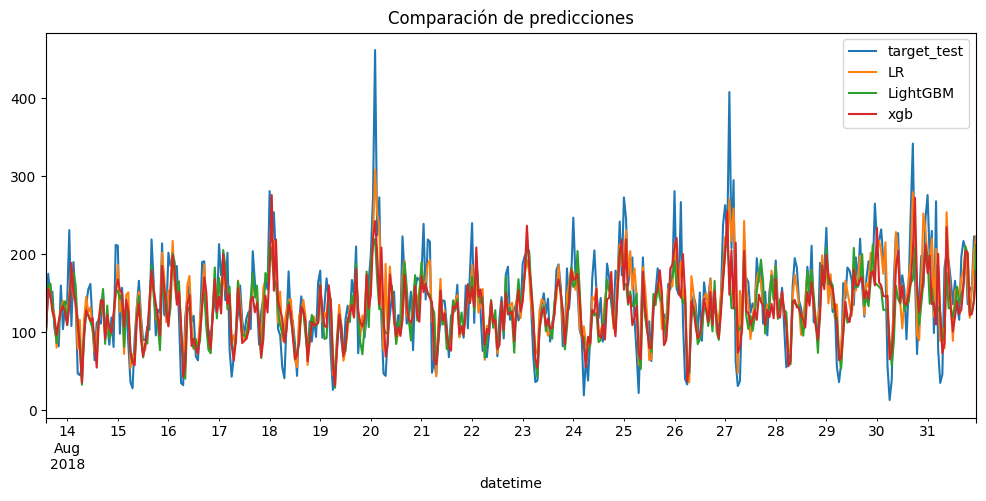

In [16]:
#Transformamos nuestros vectores de predicciones a series para poder gráficarlos juntos.
serie_lr_predicted = pd.Series(lr_predicted, index = target_test.index)
serie_y_predicted = pd.Series(y_predicted, index = target_test.index)
serie_xgb_1_predicted = pd.Series(xgb_1_predicted, index = target_test.index)

predicted_concat = pd.concat([target_test, serie_lr_predicted, serie_y_predicted, serie_xgb_1_predicted], axis= "columns")
predicted_concat.columns = ["target_test", "LR", "LightGBM", "xgb"]

predicted_concat.plot(title= "Comparación de predicciones", figsize=[12,5])


Dada la gráfica anterior, visulamente vemos que la linea naranja se asemeja más a los datos reales en los picos infimos y superiores.
